In [1]:
import gymnasium as gym

import time
import numpy as np
import matplotlib.pyplot as plt
import itertools
from tqdm.notebook import tqdm
import pandas as pd
import pickle

In [10]:
configuration = {

    # Parametrization bellow cannot be changed
    "lanes_count" : 10, # The environment must always have 10 lanes
    "vehicles_count": 50, # The environment must always have 50 other vehicles
    "duration": 120,  # [s] The environment must terminate never before 120 seconds
    "other_vehicles_type": "highway_env.vehicle.behavior.IDMVehicle", # This is the policy of the other vehicles
    "initial_spacing": 2, # Initial spacing between vehicles needs to be at most 2

    # Refer to refer to https://highway-env.farama.org/actions/ to change action space type
    "action": {
        "type": "DiscreteMetaAction",
    },

    # Parameterization bellow can be changed (as it refers mostly to the reward system)
    # "collision_reward": -10,  # The reward received when colliding with a vehicle. (Can be changed)
    # "reward_speed_range": [20, 30],  # [m/s] The reward for high speed is mapped linearly from this range to [0, HighwayEnv.HIGH_SPEED_REWARD]. (Can be changed)
    "simulation_frequency": 15, #15,  # [Hz] (Can be changed)
    "policy_frequency": 5, #5,  # [Hz] (Can be changed)

    "collision_reward": -100,  # The reward received when colliding with a vehicle.
    "right_lane_reward": 8,  # The reward received when driving on the right-most lanes, linearly mapped to
    # zero for other lanes.
    "high_speed_reward": 5,  # The reward received when driving at full speed, linearly mapped to zero for
    # lower speeds according to config["reward_speed_range"].
    "lane_change_reward": -1,  # The reward received at each lane change action.
    "reward_speed_range": [20, 30],
    "normalize_reward": False,  # True to normalize the reward to the range [-1, 0], False to return the original reward.
    
    # Parameters defined bellow are purely for visualiztion purposes! You can alter them as you please
    "screen_width": 800,  # [px]
    "screen_height": 600,  # [px]
    "centering_position": [0.5, 0.5],
    "scaling": 5,
    "show_trajectories": True,
    "render_agent": True,
    "offscreen_rendering": False
}

default_config = configuration.copy()

In [57]:
ttc_test = TimeToCollision(policy_frequency=5, simulation_frequency=15)
ttc_test.test_env(sleep_time=0)

FPS:  7.032930637310061


In [53]:
ttc_test_fast = TimeToCollision(policy_frequency=4, simulation_frequency=20)
ttc_test_fast.test_env(sleep_time=0)

FPS:  5.217737200501177


In [55]:
class TimeToCollision:
    def __init__(self, horizon=5,
                policy_frequency=1,
                simulation_frequency=10,
                render_mode=None):

        self.config = default_config.copy()
        self.config["observation"] =  {
        "type": "TimeToCollision",
        "horizon": horizon}
        self.horizon = horizon
        
        self.config['policy_frequency'] = policy_frequency
        self.config['simulation_frequency'] = simulation_frequency

        with gym.make("highway-fast-v0", config=self.config, render_mode=render_mode) as env:
            self.env = env
            # self.OBSERVATION_SPACE_VALUES = env.observation_space.shape[1:]
            self.OBSERVATION_SPACE_VALUES = env.observation_space.shape
            self.ACTION_SPACE_SIZE = env.action_space.n
    
    def get_state(self): 
        grid = self.env.get_wrapper_attr('vehicle').speed_index
        # return self.current_obs[grid]
        return self.current_obs
    
    def reset(self, seed='random'):
        if seed == 'random':
            seed = np.random.randint(100000)
        self.current_obs, info = self.env.reset(seed=seed)
        return self.get_state()
    
    def step(self, action):
        self.current_obs, reward, done, truncated, info = self.env.step(action)
        return self.get_state(), reward, done, truncated
    
    def close(self): 
        self.env.close()

    def test_env(self, sleep_time=1):
        with gym.make("highway-v0", config=self.config, render_mode=None) as env:
            self.env = env
            step = 0
            obs = env.reset()
            for _ in range(1000):
                action = env.action_space.sample()
                self.current_obs, reward, done, truncated, info = env.step(action)
                print(self.get_state(), reward)
                done = done | truncated
                if done:
                    break
                step += 1
                time.sleep(sleep_time)
        

ttc = TimeToCollision(horizon=5, 
                      policy_frequency=4, 
                      simulation_frequency=20)
# ttc.test_env(sleep_time=0)

In [12]:
from keras.models import Sequential 
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Activation, Flatten
from keras.callbacks import TensorBoard
from keras.optimizers import Adam
from IPython.display import clear_output
import matplotlib.pyplot as plt
import tensorflow as tf
from collections import deque
import random
import time
import numpy as np
import os

REPLAY_MEMORY_SIZE = 50_000
MODEL_NAME = "2x16"
MIN_REPLAY_MEMORY_SIZE = 1_000
MINIBATCH_SIZE = 64
DISCOUNT = 0.99 
UPDATE_TARGET_EVERY = 5
EPISODES = 1_000
MIN_REWARD = -100
epsilon = 1  # not a constant, going to be decayed
EPSILON_DECAY = 0.9975
MIN_EPSILON = 0.001
EVAL_FREQUENCY = 25

if not os.path.isdir('models'):
    os.makedirs('models')

random.seed(1)
np.random.seed(1)
tf.random.set_seed(1)

In [20]:
class DQNAgent:
    def __init__(self, env): 
        self.env = env
        # Main model - what gets trained every step
        self.model = self.create_model()

        # Target model - what we predict every step
        self.target_model = self.create_model()
        self.target_model.set_weights(self.model.get_weights())

        self.replay_memory = deque(maxlen=REPLAY_MEMORY_SIZE)
        
        # self.tensorboard = ModifiedTensorBoard(log_dir=f"logs/{MODEL_NAME}-{int(time.time())}")
        self.target_update_counter = 0


    def create_model(self):
        model = Sequential()
        model.add(Conv2D(16, (2, 2), input_shape=self.env.OBSERVATION_SPACE_VALUES))
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.2))

        model.add(Flatten()) 
        model.add(Dense(64))
        model.add(Dense(64))

        model.add(Dense(self.env.ACTION_SPACE_SIZE, activation='linear'))  # ACTION_SPACE_SIZE = how many choices
        model.compile(loss='mse', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
        return model 
    
    def update_replay_memory(self, transition):
        self.replay_memory.append(transition)

    def get_qs(self, state):
        return self.model.predict(np.array(state).reshape(-1, *state.shape), verbose=0)[0]

    def train(self, terminal_state): 
        if len(self.replay_memory) < MIN_REPLAY_MEMORY_SIZE:
            return 
        
        minibatch = random.sample(self.replay_memory, MINIBATCH_SIZE)

        current_states = np.array([transition[0] for transition in minibatch])
        current_qs_list = self.model.predict(current_states, verbose=0)                      # The model that gets trained every step

        new_current_states = np.array([transition[3] for transition in minibatch])
        future_qs_list = self.target_model.predict(new_current_states, verbose=0)              # The model that doesn't get trained every step

        X = []
        y = []
        
        for index, (current_state, action, reward, new_current_state, done) in enumerate(minibatch):
            if not done:
                max_future_q = np.max(future_qs_list[index])
                new_q = reward + DISCOUNT * max_future_q
            else:
                new_q = reward

            current_qs = current_qs_list[index]
            # Update the q value for the action taken
            current_qs[action] = new_q

            X.append(current_state)
            y.append(current_qs)
        
        self.model.fit(np.array(X), np.array(y), batch_size=MINIBATCH_SIZE, verbose=0, shuffle=False, 
                       #callbacks=[self.tensorboard] if terminal_state else None
                       )

        # Update target network counter every episode
        if terminal_state:
            self.target_update_counter += 1

        # If counter reaches set value, update target network with weights of main network
        if self.target_update_counter > UPDATE_TARGET_EVERY:
            self.target_model.set_weights(self.model.get_weights())
            self.target_update_counter = 0


    def evaluate(self, agent, n_games=3, t_max=1000, render=True, verbose=True):
        sim_freq, pol_freq, horizon = self.env.config['simulation_frequency'], self.env.config['policy_frequency'], self.env.horizon
        render_mode = 'human' if render else None
        ttc_env = TimeToCollision(policy_frequency=pol_freq, simulation_frequency=sim_freq, horizon=horizon, render_mode=render_mode)

        print('Evaluating...') if verbose else None
        rewards = []
        for i in tqdm(range(n_games)):
            cum_reward = 0
            steps, done = 0, False
            current_state = ttc_env.reset(seed=np.random.randint(100000))
            while not done and steps < t_max: 
                # Get next action 
                next_action = np.argmax(agent.get_qs(current_state))
                current_state, reward, done, truncated = ttc_env.step(next_action)
                done = done | truncated
                cum_reward += reward
                steps += 1
            rewards.append(cum_reward)

        ttc_env.close()
        return np.mean(rewards)



ttc = TimeToCollision(horizon=5, 
                      policy_frequency=4, 
                      simulation_frequency=20)

agent = DQNAgent(ttc)

ep_rewards = []
mean_rw_history = []
step = 1

episode = 250, episode_rewards = 445.919, epsilon = 0.52032


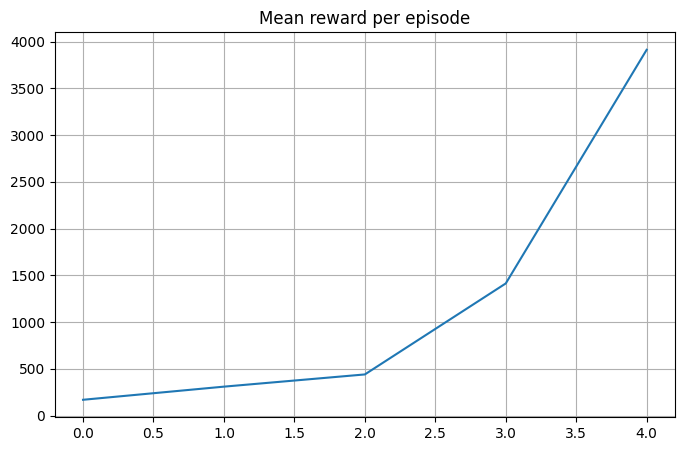

KeyboardInterrupt: 

In [21]:
for episode in tqdm(range(1, EPISODES+1), unit='episode'):
    # agent.tensorboard.step = episode

    episode_reward = 0
    current_state = ttc.reset(seed=np.random.randint(100000))
    done = False

    while not done:
        if np.random.random() > epsilon:
            action = np.argmax(agent.get_qs(current_state))
        else:
            action = np.random.randint(0, ttc.ACTION_SPACE_SIZE)

        new_state, reward, done, truncate = ttc.step(action)
        done = done | truncate

        episode_reward += reward

        # if SHOW_PREVIEW and not episode % AGGREGATE_STATS_EVERY:
        #     ttc.render()

        agent.update_replay_memory((current_state, action, reward, new_state, done))
        agent.train(done)

        current_state = new_state
        step += 1

    # Append episode reward to a list and log stats (every given number of episodes)
    ep_rewards.append(episode_reward)

    if episode % EVAL_FREQUENCY == 0:
        # eval the agent
        mean_rw_history.append(agent.evaluate(
            agent, n_games=3, t_max=1000)
        )

        clear_output(True)

        print("episode = %i, episode_rewards = %.3f, epsilon = %.5f" %
              (episode, episode_reward, epsilon))

        plt.figure(figsize=[8, 5])
        plt.title("Mean reward per episode")
        plt.plot(mean_rw_history)
        plt.grid()

        plt.show()

    # Decay epsilon
    if epsilon > MIN_EPSILON:
        epsilon *= EPSILON_DECAY
        epsilon = max(MIN_EPSILON, epsilon)

In [23]:
agent.evaluate(agent, n_games=3, t_max=1000)

Evaluating...


  0%|          | 0/3 [00:00<?, ?it/s]

KeyboardInterrupt: 